# Interpreting text models: IMDB sentiment analysis

Captum (“comprehension” in Latin) is an open source, extensible library for model interpretability built on PyTorch. The primary audiences for Captum are model developers who are looking to improve their models and understand which features are important and interpretability researchers focused on identifying algorithms that can better interpret many types of models.

The very basic intution behind Integrated Gradients (from Axiomatic Attribution for Deep Networks)

![Integrated Gradients](img/IG-Basic-Concept.png)

Why does a model think this boat is a fireboat? We find out using Integrated Gradients. In code the paper shows a simple 7 line implementation.

![What makes a fireboat a fireboat?](img/IG-Code.png)

#### Let's get ready to execute this on SageMaker

In [1]:
%%bash

pip install --upgrade pip
pip install torchtext nvidia-ml-py3 captum
pip install -U spacy torch msgpack
python -m spacy download en
python -m spacy validate

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (19.3.1)
Requirement already up-to-date: spacy in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (2.2.3)
Requirement already up-to-date: torch in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (1.3.1)
Requirement already up-to-date: msgpack in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (0.6.2)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/en_core_web_sm
-->
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Loaded compatibility table

====================== Installed models (spaCy v2.2.3) ======================
ℹ spaCy installation:
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python

In [2]:
import spacy

import torch
import torchtext
import torchtext.data
import torch.nn as nn
import torch.nn.functional as F

from torchtext.vocab import Vocab

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

nlp = spacy.load('en')

In [3]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=5)

In [5]:
#!wget -cv https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!mkdir data models
!(cd data ; wget -cv https://ar51.s3.amazonaws.com/aclImdb_v1.tar.gz)
!(cd data ; tar -xzf aclImdb_v1.tar.gz)
!(cd models ; wget -cv https://ar51.s3.amazonaws.com/imdb-model-cnn.pt)

--2019-12-05 00:58:01--  https://ar51.s3.amazonaws.com/aclImdb_v1.tar.gz
Resolving ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)... 52.216.98.43
Connecting to ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)|52.216.98.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.3MB/s    in 4.1s    

2019-12-05 00:58:06 (19.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

--2019-12-05 00:58:09--  https://ar51.s3.amazonaws.com/imdb-model-cnn.pt
Resolving ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)... 52.216.115.91
Connecting to ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)|52.216.115.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20666233 (20M) [binary/octet-stream]
Saving to: ‘imdb-model-cnn.pt’

imdb-model-cnn.pt   100%[===================>]  19.71M  15.6MB/s    in 1.3s    

2019-12-05 00:58:11 (15.6 MB/s) - 

In [6]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        #text = text.permute(1, 0)
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

In [7]:
!ls models

imdb-model-cnn.pt


In [8]:
model = torch.load('models/imdb-model-cnn.pt')
model.eval()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you c

CNN(
  (embedding): Embedding(101982, 50, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))

In [10]:
TEXT = torchtext.data.Field(lower=True, tokenize='spacy')
Label = torchtext.data.LabelField(dtype = torch.float)

In [11]:
train, test = torchtext.datasets.IMDB.splits(text_field=TEXT,
                                      label_field=Label,
                                      train='train',
                                      test='test',
                                      path='data/aclImdb')
test, _ = test.split(split_ratio = 0.04)

In [12]:
#!wget -cv http://nlp.stanford.edu/data/glove.6B.zip
!(cd data ; wget -cv https://ar51.s3.amazonaws.com/glove.6B.50d.txt.tar.gz)
!(cd data ; tar -xzf glove.6B.50d.txt.tar.gz)

--2019-12-05 00:59:48--  https://ar51.s3.amazonaws.com/glove.6B.50d.txt.tar.gz
Resolving ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)... 52.216.133.243
Connecting to ar51.s3.amazonaws.com (ar51.s3.amazonaws.com)|52.216.133.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69182665 (66M) [application/x-tar]
Saving to: ‘glove.6B.50d.txt.tar.gz’

glove.6B.50d.txt.ta 100%[===================>]  65.98M  18.8MB/s    in 3.5s    

2019-12-05 00:59:52 (18.8 MB/s) - ‘glove.6B.50d.txt.tar.gz’ saved [69182665/69182665]



In [13]:
!ls data/glove.6B.50d.txt

data/glove.6B.50d.txt


In [14]:
from torchtext import vocab

#loaded_vectors = vocab.GloVe(name='6B', dim=50)

# If you prefer to use pre-downloaded glove vectors, you can load them with the following two command line
loaded_vectors = torchtext.vocab.Vectors('data/glove.6B.50d.txt')
TEXT.build_vocab(train, vectors=loaded_vectors, max_size=len(loaded_vectors.stoi))
    
TEXT.vocab.set_vectors(stoi=loaded_vectors.stoi, vectors=loaded_vectors.vectors, dim=loaded_vectors.dim)
Label.build_vocab(train)

100%|█████████▉| 398388/400000 [00:20<00:00, 19085.11it/s]

In [15]:
print('Vocabulary Size: ', len(TEXT.vocab))

Vocabulary Size:  101520


In [16]:
PAD_IND = TEXT.vocab.stoi['pad']

In [17]:
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [18]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'embedding')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/captum/attr/_models/base.py:165: UserWarning: In order to make embedding layers more interpretable they will
        be replaced with an interpretable embedding layer which wraps the
        original embedding layer and takes word embedding vectors as inputs of
        the forward function. This allows to generate baselines for word
        embeddings and compute attributions for each embedding dimension.
        The original embedding layer must be set
        back by calling `remove_interpretable_embedding_layer` function
        after model interpretation is finished.
  after model interpretation is finished."""


In [19]:
ig = IntegratedGradients(model)

In [20]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    
    model.zero_grad()

    input_indices = torch.LongTensor(indexed)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # pre-computing word embeddings
    input_embedding = interpretable_embedding.indices_to_embeddings(input_indices)

    # predict
    pred = forward_with_sigmoid(input_embedding).item()
    pred_ind = round(pred)

    # generate reference for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)
    reference_embedding = interpretable_embedding.indices_to_embeddings(reference_indices)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, reference_embedding, n_steps=500, return_convergence_delta=True)

    print('pred: ', Label.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            Label.vocab.itos[pred_ind],
                            Label.vocab.itos[label],
                            Label.vocab.itos[1],
                            attributions.sum(),       
                            text[:len(attributions)],
                            delta))

In [21]:
torch.cuda.is_available()

True

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [23]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.99 ) , delta:  tensor([2.1458e-05])
pred:  pos ( 1.00 ) , delta:  tensor([6.6757e-05])
pred:  pos ( 1.00 ) , delta:  tensor([0.0003])
pred:  pos ( 0.69 ) , delta:  tensor([0.0003])
pred:  neg ( 0.22 ) , delta:  tensor([0.0011])
pred:  pos ( 0.80 ) , delta:  tensor([0.0008])


In [24]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


Target Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,-0.61,It was a fantastic performance ! pad
pos,pos (1.00),pos,-1.10,Best film ever pad pad pad pad
pos,pos (1.00),pos,-0.59,Such a great show ! pad pad
neg,pos (0.69),pos,-1.82,It was a horrible movie pad pad
neg,neg (0.22),pos,-2.45,I 've never watched something as bad
neg,pos (0.80),pos,-2.02,It is a disgusting movie ! pad


In [25]:
vis_data_records_ig

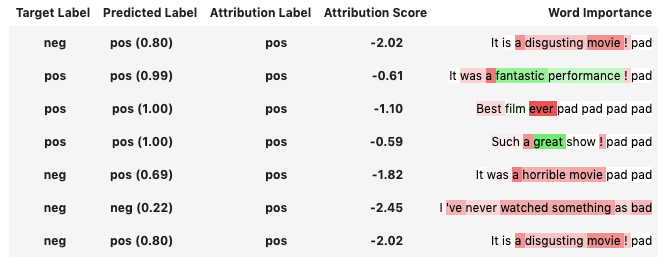

100%|█████████▉| 398388/400000 [00:40<00:00, 19085.11it/s]

In [26]:
from IPython.display import Image
Image(filename='img/sentiment_analysis.png')


#### Sources & References: 

* https://captum.ai/tutorials/IMDB_TorchText_Interpret
* https://captum.ai/docs/introduction.html
* https://captum.ai/docs/extension/integrated_gradients
* https://arxiv.org/pdf/1703.01365.pdf
* https://towardsdatascience.com/interpretable-neural-networks-45ac8aa91411
* https://github.com/ankurtaly/Integrated-Gradients
* http://theory.stanford.edu/~ataly/Talks/sri_attribution_talk_jun_2017.pdf
* https://medium.com/@kartikeyabhardwaj98/integrated-gradients-for-deep-neural-networks-c114e3968eae
* http://www.unofficialgoogledatascience.com/2017/03/attributing-deep-networks-prediction-to.html
* https://psturmfels.github.io/VisualizingExpectedGradients/
* https://www.youtube.com/watch?v=iVSIFm0UN9I
* https://medium.com/@SeoJaeDuk/archived-post-axiomatic-attribution-for-deep-networks-b4af79d5ed32
* http://pages.cs.wisc.edu/~jiefeng/docs/neurips2019/poster.pdf
* http://pages.cs.wisc.edu/~jiefeng/docs/neurips2019/slides.pdf
* https://vimeo.com/238242575